Link dataset on gg drive: https://drive.google.com/drive/folders/1EINfyZxIc0kP4PH7XyZBqeZMjJAxmrP2?usp=sharing

# Generative Adversarial Network
Auto generate images

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU, ReLU, PReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

%matplotlib inline

Read image from "data_dir"
use img 64x64

In [ ]:
def read_images(data_dir):
    images = list()
    for file_name in glob.glob(data_dir + '/*.jpg'):
        img = image.load_img(file_name)
        img = image.img_to_array(img)
        img = cv2.resize(img, (int(64), int(64)))
        images.append(img)
    return np.asarray(images) / 255.0

Build the generator

In [ ]:
def build_generator(latent_dim):
    """
    Builds the generator model
    """
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    model = Sequential(name='generator')

    model.add(Dense(4 * 4 * 1024, kernel_initializer=init, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4, 4, 1024)))

    model.add(Conv2DTranspose(512, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same',kernel_initializer=init))
    model.add(Activation('tanh'))

    model.summary()

    return model

Build the Discriminator

In [ ]:
def build_discriminator(image_shape=(64,64,3)):

    """
    Builds the generator model
    """
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    model = Sequential(name='discriminator')

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=image_shape, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, kernel_size=5, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, kernel_initializer=init))
    model.add(Activation('sigmoid'))

    model.summary()

    return model

Build Model

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
class DCGAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @tf.function
    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator
        with tf.GradientTape() as discriminator_tape:
            generated_images = self.generator(random_latent_vectors)
            real_output = self.discriminator(real_images)
            fake_output = self.discriminator(generated_images)
            d_loss = self.discriminator_loss(real_output, fake_output)
        discriminator_grads = discriminator_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(discriminator_grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the generator
        with tf.GradientTape() as generator_tape:
            generated_images = self.generator(random_latent_vectors)
            fake_output = self.discriminator(generated_images)
            g_loss = self.generator_loss(fake_output)
        generator_grads = generator_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(generator_grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            'd_loss': self.d_loss_metric.result(),
            'g_loss': self.g_loss_metric.result(),
        }


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            fig = plt.figure(figsize=(10, 4))
            for i in range(self.num_img):
                plt.subplot(2, 5, i + 1)
                plt.imshow(generated_images[i,:,:,:] * 0.5 + 0.5)
                plt.axis('off')
            plt.show()

In [ ]:
latent_dim = 128

generator = build_generator(latent_dim)
discriminator = build_discriminator()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             2113536   
                                                                 
 batch_normalization_7 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 512)        13107712  
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 512)        20

In [ ]:
gan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
)

Read dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = read_images('/content/drive/My Drive/Dataset/cats')
dataset.shape

(3367, 64, 64, 3)

Train the model

Epoch 1/50
106/106 [==============================] - ETA: 0s - d_loss: 1.4064 - g_loss: 0.9532

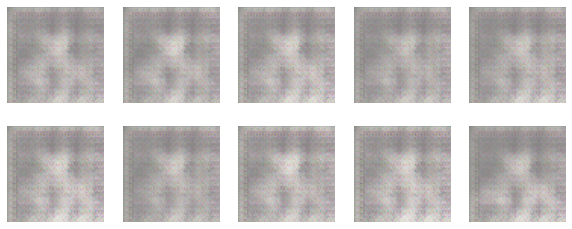

106/106 [==============================] - 38s 344ms/step - d_loss: 1.4064 - g_loss: 0.9532
Epoch 2/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3017 - g_loss: 0.8536
Epoch 3/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3215 - g_loss: 0.8449
Epoch 4/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3079 - g_loss: 0.9013
Epoch 5/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3613 - g_loss: 0.8740
Epoch 6/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3527 - g_loss: 0.7887
Epoch 7/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3298 - g_loss: 0.8097
Epoch 8/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3407 - g_loss: 0.8577
Epoch 9/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3481 - g_loss: 0.8652
Epoch 10/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.33

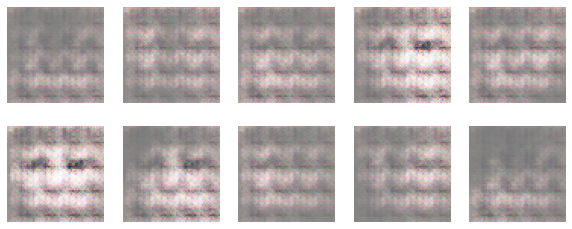

106/106 [==============================] - 36s 338ms/step - d_loss: 1.3205 - g_loss: 0.9323
Epoch 12/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3102 - g_loss: 0.9686
Epoch 13/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3468 - g_loss: 0.8897
Epoch 14/50
106/106 [==============================] - 35s 333ms/step - d_loss: 1.3420 - g_loss: 0.8839
Epoch 15/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3518 - g_loss: 0.8339
Epoch 16/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3319 - g_loss: 0.8839
Epoch 17/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3440 - g_loss: 0.8447
Epoch 18/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3544 - g_loss: 0.8907
Epoch 19/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3575 - g_loss: 0.8067
Epoch 20/50
106/106 [==============================] - 35s 334ms/step - d_lo

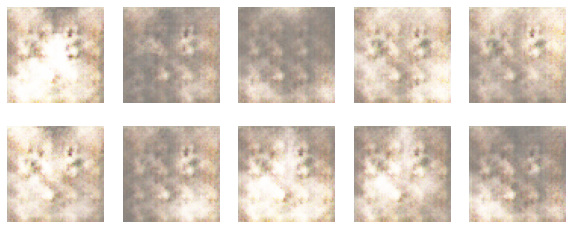

106/106 [==============================] - 36s 339ms/step - d_loss: 1.3248 - g_loss: 0.8670
Epoch 22/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3876 - g_loss: 0.8674
Epoch 23/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3577 - g_loss: 0.8335
Epoch 24/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3495 - g_loss: 0.8620
Epoch 25/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3529 - g_loss: 0.8482
Epoch 26/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3682 - g_loss: 0.8308
Epoch 27/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3515 - g_loss: 0.8109
Epoch 28/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3543 - g_loss: 0.8207
Epoch 29/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3567 - g_loss: 0.8368
Epoch 30/50
106/106 [==============================] - 35s 333ms/step - d_lo

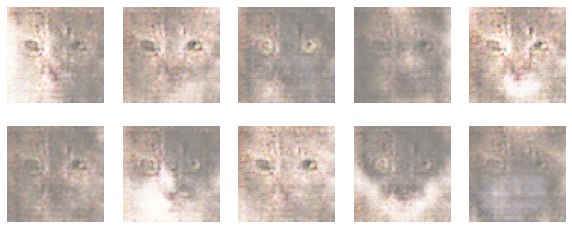

106/106 [==============================] - 36s 338ms/step - d_loss: 1.3386 - g_loss: 0.8347
Epoch 32/50
106/106 [==============================] - 35s 333ms/step - d_loss: 1.3131 - g_loss: 0.8562
Epoch 33/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3629 - g_loss: 0.8569
Epoch 34/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3855 - g_loss: 0.7967
Epoch 35/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3572 - g_loss: 0.8614
Epoch 36/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3603 - g_loss: 0.8588
Epoch 37/50
106/106 [==============================] - 35s 333ms/step - d_loss: 1.3707 - g_loss: 0.8150
Epoch 38/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3557 - g_loss: 0.8366
Epoch 39/50
106/106 [==============================] - 35s 333ms/step - d_loss: 1.3566 - g_loss: 0.8454
Epoch 40/50
106/106 [==============================] - 35s 334ms/step - d_lo

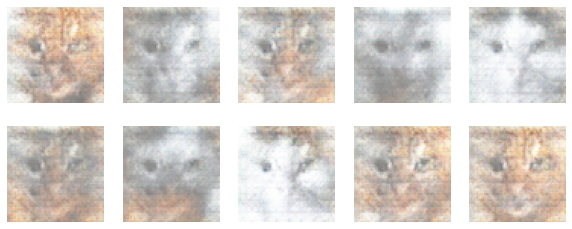

106/106 [==============================] - 36s 338ms/step - d_loss: 1.3623 - g_loss: 0.8101
Epoch 42/50
106/106 [==============================] - 35s 335ms/step - d_loss: 1.3940 - g_loss: 0.7734
Epoch 43/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3624 - g_loss: 0.7969
Epoch 44/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3720 - g_loss: 0.8050
Epoch 45/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3710 - g_loss: 0.8087
Epoch 46/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3582 - g_loss: 0.8125
Epoch 47/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3842 - g_loss: 0.7580
Epoch 48/50
106/106 [==============================] - 35s 334ms/step - d_loss: 1.3599 - g_loss: 0.8042
Epoch 49/50
106/106 [==============================] - 35s 333ms/step - d_loss: 1.3571 - g_loss: 0.8191
Epoch 50/50
106/106 [==============================] - 35s 334ms/step - d_lo

In [ ]:
history=gan.fit(dataset, epochs=50, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Loss function values

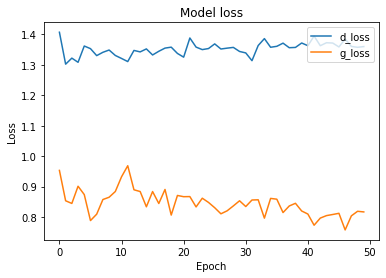

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

Auto generate images

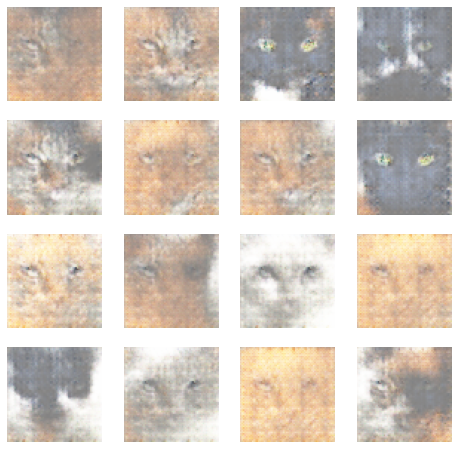

In [ ]:
noise = tf.random.normal([16, 128])
generated_images = gan.generator(noise)

fig = plt.figure(figsize=(8, 8))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((generated_images[i,:,:,:] * 0.5 + 0.5))
    plt.axis("off")
plt.show()